In [1]:
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from utils.generators import UserGenerator

In [3]:
ug = UserGenerator()

In [4]:
dat = ug.generate_lift_data(1000,0.1,0.5,1)

In [8]:
# extract and sort by time

dat['hour'] = dat.datetime.dt.hour

dat = dat.reset_index()[['user_id','datetime','purchased','hour']]

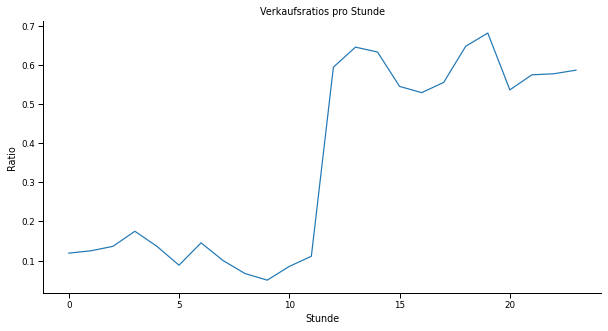

In [9]:
fig = plt.figure(figsize=(10,5))
sns.set_context("paper")
ax = sns.lineplot( data=dat.groupby('hour')['purchased'].mean() )
ax.set_title("Verkaufsratios pro Stunde")
ax.set(xlabel='Stunde', ylabel='Ratio')
sns.despine()

In [10]:
dat.sample(10)

,user_id,datetime,purchased,hour
826,uid_6306,2020-01-01 19:58:33,0,19
321,uid_6652,2020-01-01 07:37:17,0,7
134,uid_5889,2020-01-01 03:12:07,0,3
613,uid_6347,2020-01-01 15:06:29,1,15
220,uid_6800,2020-01-01 05:14:52,0,5
945,uid_6565,2020-01-01 22:48:10,0,22
651,uid_6811,2020-01-01 16:00:20,0,16
133,uid_6675,2020-01-01 03:11:14,0,3
498,uid_6821,2020-01-01 12:22:27,0,12
750,uid_6524,2020-01-01 18:22:05,1,18


In [17]:
with pm.Model() as model:
    
    lambda_1 = pm.Uniform("lambda_1",  lower=0, upper=1)
    lambda_2 = pm.Uniform("lambda_2",  lower=0, upper=1)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=dat.shape[0] - 1)
    
    # to be able to tell the index point of change we need to add an index
    index = np.arange(dat.shape[0])
    
    # a switch to find the point of interest
    lambda_ = pm.math.switch(tau > index, lambda_1, lambda_2)
    
    observation = pm.Binomial("obs", p=lambda_, n=dat.shape[0], observed=dat.purchased)

    # initializer 
    start = pm.find_MAP()
    # NUTS sampler
    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000, step=step, discard_tuned_samples=True)

logp = -768.67, ||grad|| = 225.96: 100%|██████████| 19/19 [00:00<00:00, 3624.17it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5473.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
#len(trace['tau'])

40000

In [12]:
tau_post = trace['tau'][:5000]

lambda_1 = trace['lambda_1'][:5000] * dat.shape[0]
lambda_2 = trace['lambda_2'][:5000] * dat.shape[0]


Clean up the date time inference

/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


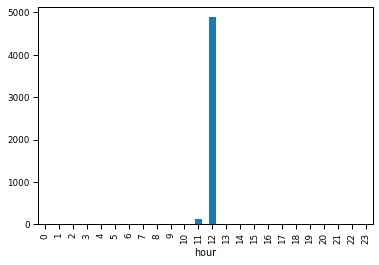

In [23]:
dat_time = dat[['hour']]
dat_time['posterior_split'] = dat_time.index.to_series().map(Counter(tau_post))
dat_time.groupby('hour')['posterior_split'].sum().plot(kind='bar')

[Text(0, 0.5, 'Relative Häufigkeit'), Text(0.5, 0, 'Index')]

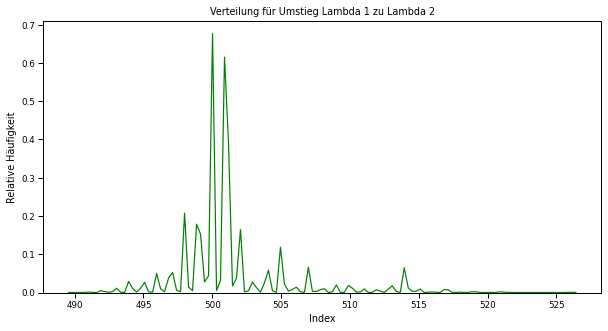

In [64]:
fig = plt.figure(figsize=(10,5))
ax = sns.distplot(tau_post,color='g', hist=False)
ax.set_title("Verteilung für Umstieg Lambda 1 zu Lambda 2")
ax.set(xlabel='Index', ylabel='Relative Häufigkeit')

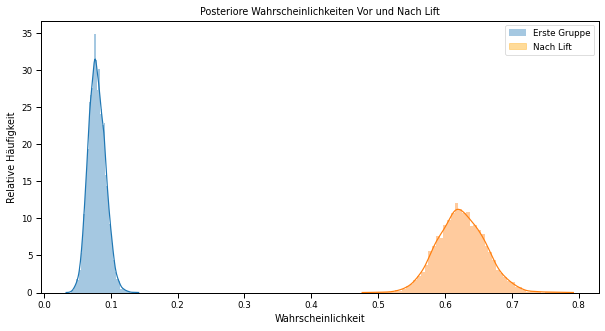

In [71]:

fig = plt.figure(figsize=(10,5))
ax = sns.distplot(lambda_1)
sns.distplot(lambda_2)
ax.set_title("Posteriore Wahrscheinlichkeiten Vor und Nach Lift")
ax.set(xlabel='Wahrscheinlichkeit', ylabel='Relative Häufigkeit')
legend = ax.legend(labels=["Erste Gruppe","Nach Lift"])
legend.legendHandles[1].set_color('orange')


In [99]:
# Automate the process

def calculate_posterior(ug, n_samples , initial_rate, lift,user_ratio=0.5 ):
    nr_of_days = 1
    hour_split = int((nr_of_days*24) * user_ratio )
    
    # create dataset
    dat = ug.generate_lift_data(n_samples,initial_rate,lift,nr_of_days, user_ratio=user_ratio)
    
    
    # parse_time
    dat['hour'] = dat.datetime.dt.hour
    dat = dat.reset_index()[['user_id','datetime','purchased','hour']]
    #return dat
    # sample it
    trace_sampled = run_sampler(dat)
    
    tau_post = trace_sampled['tau'][:5000]
    
    dat_time = dat[['hour']]
    dat_time['posterior_split'] = dat_time.index.to_series().map(Counter(tau_post))
    
    time_split = dat_time.groupby('hour')['posterior_split'].sum()
    lambda_1_trace = trace_sampled['lambda_1'] * dat.shape[0]
    lambda_2_trace = trace_sampled['lambda_2'] * dat.shape[0]
    
    # accuracy for time prediction
    time_accuracy = time_split[hour_split] / time_split.sum()
    

    return lambda_1_trace, lambda_2_trace, time_accuracy
    # return accuracy
    

def run_sampler(dat):
    
    with pm.Model() as model:
    
        lambda_1 = pm.Uniform("lambda_1",  lower=0, upper=1)
        lambda_2 = pm.Uniform("lambda_2",  lower=0, upper=1)
    
        tau = pm.DiscreteUniform("tau", lower=0, upper=dat.shape[0] - 1)
    
        # to be able to tell the index point of change we need to add an index
        index = np.arange(dat.shape[0])
    
        # a switch to find the point of interest
        lambda_ = pm.math.switch(tau > index, lambda_1, lambda_2)
    
        observation = pm.Binomial("obs", p=lambda_, n=dat.shape[0], observed=dat.purchased)

        # initializer 
        start = pm.find_MAP()
        # NUTS sampler
        step = pm.NUTS()
        trace = pm.sample(15000, tune=7000,step=step, discard_tuned_samples=True)
        
    return trace

In [101]:
user_numbers = [1000]
lift_detection = {}
dataframe = pd.DataFrame()
for n_users in user_numbers:
    for lift in np.linspace(0.05,0.5,num=10):
    
        lambda_1, lambda_2, time_accuracy = calculate_posterior(ug, 1000, 0.1, lift, user_ratio=0.25 )
    
    
        lift_detection[lift] = {'l1':lambda_1.mean(), 
                                'l2':lambda_2.mean(), 
                                "time_accuracy":time_accuracy }
        
        
    dat = pd.DataFrame.from_dict(lift_detection, orient='index')
    dat['usernumber'] = n_users
    
    dataframe = dataframe.append(dat)
    

logp = -606.36, ||grad|| = 267.84: 100%|██████████| 19/19 [00:00<00:00, 3350.22it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 654 divergences: 100%|██████████| 88000/88000 [00:18<00:00, 4850.15draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8919081150583968, but should be close to 0.8. Try to increase the number of tuning steps.
There were 639 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6899322778454049, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates sl

logp = -878.69, ||grad|| = 193.58: 100%|██████████| 18/18 [00:00<00:00, 3900.67it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 88000/88000 [00:17<00:00, 5102.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NameError: name 'lift_detection' is not defined